In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import os
import sys
from sklearn.preprocessing import StandardScaler
root = "/project/wyin/jlee/ml-project/"
util_loc = os.path.join(root, "utils")
sys.path.append(util_loc)
from forward_utilities import LitNeuralNet, ScaledData, see_results
import time

data_loc = os.path.join(root, "dos-prediction-full/data")
model_loc = os.path.join(root, "dos-prediction-full/neural-nets/ensembling/logs/long-run-24")

In [3]:
models = []
same_models = []
for i in range(24):
    log_dir = os.listdir(model_loc)[i]
    check_dir = os.path.join(model_loc, log_dir, "version_0/checkpoints")
    check_file = os.listdir(check_dir)[0]
    check_path = os.path.join(check_dir, check_file)
    model = LitNeuralNet.load_from_checkpoint(checkpoint_path=check_path)
    model_name = log_dir.rpartition(']')[0] + ']'
    
    if model_name != "[3, 256, 512, 768, 1024, 301]":
        models.append((model_name, model))
        
print(len(models))
print(len(same_models))

14
0


In [4]:
all_data = ScaledData(data_loc)
train_params_arr = torch.from_numpy(all_data.val_params).float()
train_dos_arr = torch.from_numpy(all_data.val_params).float()
val_params_arr = torch.from_numpy(all_data.val_params).float()
val_dos_arr = torch.from_numpy(all_data.val_dos).float()

In [5]:
def mse_val(model):
    predicted = model.forward_prop(val_params_arr)
    return F.mse_loss(predicted, val_dos_arr).item()

sorted_models = sorted(models, key = lambda x : mse_val(x[1]))
best_model = sorted_models[0][1]
print(best_model)

LitNeuralNet(
  (forward_prop): Sequential(
    (0): Linear(in_features=3, out_features=170, bias=True)
    (1): ReLU()
    (2): Linear(in_features=170, out_features=340, bias=True)
    (3): ReLU()
    (4): Linear(in_features=340, out_features=510, bias=True)
    (5): ReLU()
    (6): Linear(in_features=510, out_features=680, bias=True)
    (7): ReLU()
    (8): Linear(in_features=680, out_features=850, bias=True)
    (9): ReLU()
    (10): Linear(in_features=850, out_features=1020, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1020, out_features=301, bias=True)
  )
)


In [6]:
test_params_tensor = torch.from_numpy(all_data.test_params).float()
predicted = best_model.forward_prop(test_params_tensor).detach().numpy()

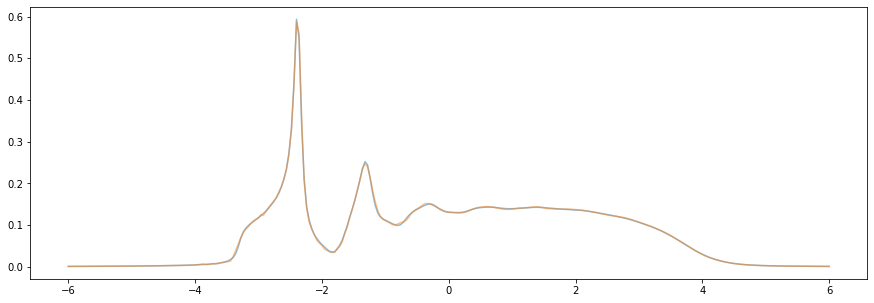

In [11]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(np.linspace(-6, 6, 301), all_data.test_dos[0], alpha = 0.5)
ax.plot(np.linspace(-6, 6, 301), predicted[0], alpha = 0.5)

model mse: 4.509821917741644e-06


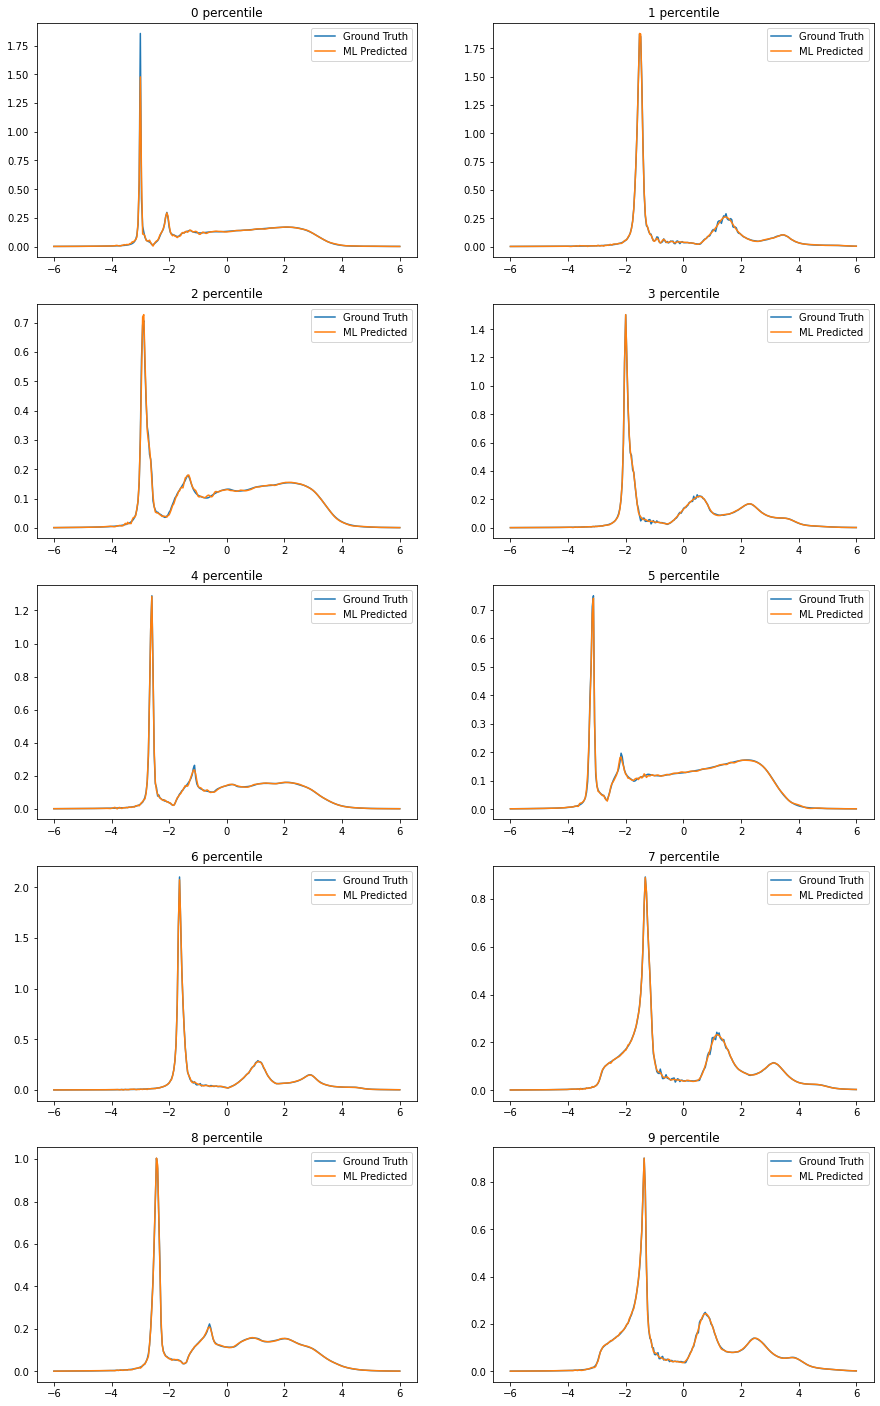

In [7]:
see_results(predicted, all_data.test_dos, (5, 2), np.arange(0, 10))

In [9]:
#Time test
start_time = time.time()
all_data = ScaledData(data_loc)

train_params_tensor = torch.from_numpy(all_data.train_params).float()
val_params_tensor = torch.from_numpy(all_data.val_params).float()
test_params_tensor = torch.from_numpy(all_data.test_params).float()

train_predicted = best_model.forward_prop(train_params_tensor).detach().numpy()
val_predicted = best_model.forward_prop(val_params_tensor).detach().numpy()
test_predicted = best_model.forward_prop(test_params_tensor).detach().numpy()

print(np.mean((train_predicted - all_data.train_dos)**2))
print(train_predicted.shape)
end_time = time.time()
print(end_time - start_time)

3.523580476710255e-06
(106120, 301)
1.237222671508789
